# Magic the Gathering Price Predictor
## Summary:
The purpose of this notebook is to output price predictions for modern staples as determined by a pretrained LSTM RNN. This neural network is trained on historical price and tournament play data, using a 30 day lag time and makes predictions for 7 days into the future. 

## About the dataset
All of the price and tournament play data were webscraped from MTGGoldfish.com. There are over 300 cards in the dataset and there are options for keeping the dataset up to date in this notebook.

AllTourneys.json contains every modern tournament decklist up to date. Each entry contains the tournament Date, a unique tournament id_num and a list of decklists reported for that tournament (usually a top-16 or all 5-0 decks for online tournaments). 

Copies_Played_Culled.csv has reduced the data from AllTourneys.json to card counts for each tournament in the dataset. There are 342 columns, one for each card and an additional column for the total number of cards played in decks for that tournament (for normalization).

All_Prices.csv contains historical pricing data for the cards in the dataset. Some price histories go as far back as 2011, but many of the cards are not even that old. 

The files DataIngestion.py and MTGDeckScraper.py contain useful functions for scraping new data from mtggoldfish and keeping these files up to date automatically. 

Finally, SetList.json and AllCards.json are files downloaded from [MTGJSON](https://mtgjson.com/) for determining printings and other card characteristics during the scraping process. These files can be kept up to date by downloading the latest versions from their website periodically (they should remain up to date for months) 

In [2]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mpld3
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Conv3D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from SeriesToSupervised import difference, diff_scale, forecast_lstm
from SeriesToSupervised import inverse_difference, inverse_transform, series_to_supervised
from SeriesToSupervised import prepare_data, getRidgePred

Using TensorFlow backend.


## Card Selection
Here you may select a card from the dataset. Price and tournament play data will be loaded and price predictions will be made for this card. Some suggestions: 'Snapcaster Mage', 'Tarmogoyf', 'Chalice of the Void', 'Teferi, Hero of Dominaria', 'Kolaghan\'s Command', 'Jace, the Mind Sculptor'

In [40]:
#Select a card
card = 'Tarmogoyf'

You may run this cell to return the full list of cards in the dataset

In [ ]:
Prices = pd.read_csv('All_Prices.csv')
Card_list = list(Prices.keys()[1:])
Card_list.sort()
for c in Card_list:
    print(c)

## Load the Predictions
### Running this cell completes the following actions: 
-Load price and tournament play data 
<br/> -Load the trained neural network and generate predictions
<br/> -Train a ridge regressor on the price data and return predictions

In [44]:
#Load pretrained LSTM model

#Do not change these parameters, the NN takes a 30 day lag as input
n_neurons = 60
n_lag = 30
n_seq = 7
n_test = 400

model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(1, 1, n_lag*2),
               kernel_initializer='random_uniform', return_sequences=True, stateful=True))
#model.add(Conv1D(filters = 32, kernel_size = [5], padding='same'))
model.add(LSTM(n_neurons-1, stateful=True))
#model.add(LSTM(n_neurons))
#model.add(Dropout(0.4))
model.add(Dense(n_seq))
model.compile(loss=['mean_squared_error'], optimizer='adam')
model.load_weights('Train_on_All.h5')

#Load price data
Prices = pd.read_csv('All_Prices.csv')
Prices['Date'] = pd.to_datetime(Prices['Date'])
Price = Prices[['Date',card]]
Price = Price.fillna(method='ffill')
Price = Price.dropna()

#Load Tournament Data
Copies = pd.read_csv('Copies_Played_Culled.csv')
Copies['Date'] = pd.to_datetime(Copies['Date'])
Copies = Copies.set_index('Date')
Resamp = Copies.resample('D').sum()

#Converting to meta_share for predictions
Resamp['Meta_Share'] = Resamp[card]/Resamp['Total']
Resamp['Date'] = Resamp.index
df_test = Price.merge(Resamp[['Meta_Share']],
                      how='outer', left_on = 'Date', right_on = 'Date')
df_test = df_test.sort_values(by='Date')
df_test = df_test.fillna(method='ffill')
df_test.dropna(inplace=True)
df_test = df_test.set_index('Date')

#Converting time-series data to supervised learning format
scaler_p, dataset_p = diff_scale(df_test[card])
scaler_m, dataset_m = diff_scale(df_test['Meta_Share'])

X_pred = np.concatenate((dataset_p[-30:], dataset_m[-30:]))
y_scaled = forecast_lstm(model,X_pred,1)

#Getting NN predictions
Future_NN = inverse_transform(df_test[card].values[-1],y_scaled,scaler_p)
Future_NN = np.append(df_test[card].values[-1],Future_NN)
f_list_NN = [[df_test.index[-1] +
           pd.tseries.offsets.DateOffset(i),Future_NN[i]] for i in range(0,n_seq+1)]

df_fut_NN = pd.DataFrame(data = f_list_NN, columns=['Date','Price'])
df_fut_NN = df_fut_NN.set_index('Date')

#fitting ridge regressor and getting predictions
df_fut_R = getRidgePred(df_test[card],n_test,n_lag,n_seq)

/opt/conda/envs/data3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Plotting 
The next few cells are for visualizing the predictions. Here are the options: <br/>
-Set plot_tournament to True for a non-interactable plot of historical price and tournament play data superimposed on the same axes. <br/>
-Set plot_tournament to False for an interactable plot of historical price data and both the Neural Network and Ridge price predictions.

In [39]:
plot_tournament = True #Set to true if you want to also see tournament play frequency

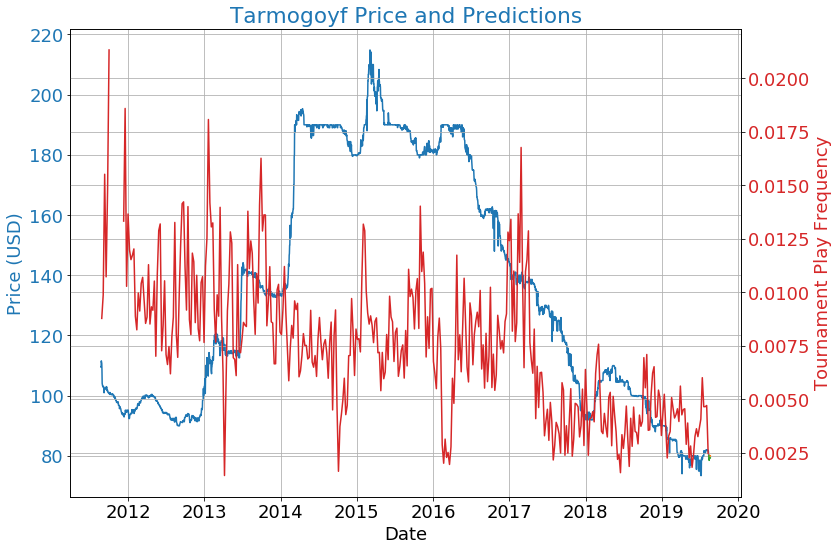

In [45]:
#Run this cell to plot prepared data and predictions

%matplotlib inline
mpld3.enable_notebook()

matplotlib.rcParams.update({'figure.figsize':[12,8],'font.size': 18})
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.plot(df_test.index,df_test[card],color = color)
ax1.plot(df_fut_R.index,df_fut_R.Price, 'tab:orange')
ax1.plot(df_fut_NN.index,df_fut_NN.Price, 'tab:green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)', color=color)
ax1.set_title(card+ ' Price and Predictions', color=color)
ax1.grid()


if plot_tournament:
    color = 'tab:red'
    mpld3.disable_notebook()
    ax2 = ax1.twinx()
    weekly = Copies.resample('W').sum()
    weekly['Meta_Share'] = weekly[card]/weekly['Total']
    ax2.plot(weekly.index,weekly.Meta_Share,color = color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Tournament Play Frequency', color=color)
    ax2.grid()
else:    
    ax1.legend(['Historical','Ridge','LSTM'])
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Updating the dataset
### WARNING: This takes a while to run
Run this cell to update the csv's storing price and tournament play data. This is done via webscraping on MTGGoldfish

In [ ]:
import DataIngestion

DataIngestion.Update_Tourneys(2)
DataIngestion.UpdatePrices()